In [1]:
import xarray
import pandas

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils.ecIndex as ec
import utils._indexDefinitions as _index

%run helpers/impactPlots.ipynb

In [3]:
nino34Domain=_index.sstIndex['nino34']

nino34Domain

{'latMin': -5, 'latMax': 5, 'longMin': 190, 'longMax': 240}

In [4]:
#figure out where to plot nino34 box on anomaly plots
mapCentre=210
nino34Box={
    'xy':[nino34Domain['longMin']-mapCentre, nino34Domain['latMin']],
    'width':nino34Domain['longMax']-nino34Domain['longMin'],
    'height':nino34Domain['latMax']-nino34Domain['latMin']
}

nino34Box

{'xy': [-20, -5], 'width': 50, 'height': 10}

# Load the sst dataset

In [5]:
paths = !find /scratch/w35/as2285/ersst/*.nc

In [6]:
xrLs=list()
for iPath in paths:
    xrLs.append(
        to_365day_monthly(
            xarray.open_dataset(iPath, use_cftime=True).isel(lev=0,drop=True)
        )
    )
sstXr=xarray.concat(xrLs,'time')

In [7]:
sstClimat=sst.calculateClimatology(sstXr.sst)

In [8]:
sstIndex=sst.calculateIndex(sstXr.sst, sstClimat)

In [9]:
indexXr=tp.averageForTimePeriod(sstIndex)

In [10]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables:
    eastIONoDetrend         (year) float64 -0.2096 0.2706 ... -0.5503 0.4041
    nino34                  (year) float64 1.198 0.3367 ... -0.02116 -1.019
    nino34NoDetrend         (year) float64 1.183 0.1822 ... 0.4823 -0.8275
    westIO                  (year) float64 -0.3837 -0.211 ... 0.438 0.1493
    backgroundSstNoDetrend  (year) float64 -0.01563 -0.1544 ... 0.5034 0.1919
    nino3                   (year) float64 1.068 0.02561 ... -0.3024 -0.8708
    nino4                   (year) float64 0.4491 0.2838 ... 0.4623 -0.6939
    eastIO                  (year) float64 -0.1259 0.4451 ... -1.003 0.1331
    dmi                     (year) float64 -0.2578 -0.656 ... 1.441 0.01628
    westIONoDetrend         (year) float64 -0.4674 -0.3855 ... 0.8908 0.4204
    nino4NoDetrend          (year) float64 0.4334 0.1294 ... 0.9657 -0.502

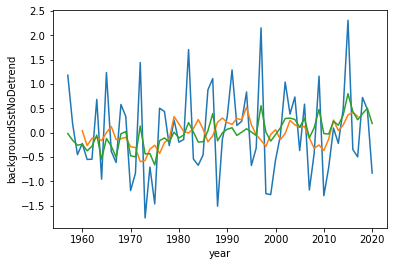

In [11]:
indexXr.nino34NoDetrend.plot()
indexXr.nino34NoDetrend.rolling(year=7,center=True).mean('year').plot()
indexXr.backgroundSstNoDetrend.plot()

In [12]:
varsToDetrend=[
    'dmi',
    'eastIO',
    'nino34',
    'westIO',
    'nino4',
    #'samWinter',
    #'samSummer'
]

In [13]:
#detrend
indexXr['dmiNoDetrend']=indexXr.dmi
            
for iVar in varsToDetrend:
    indexXr[iVar]=(
        indexXr[iVar+'NoDetrend']
        -indexXr[iVar+'NoDetrend'].rolling(
            year=11,min_periods=5,center=True
        ).mean('year')
    )




In [14]:
# and EC index too
sstAnoms=ec.sstAnoms(sstXr.sst, sstXr.sst)

#create the solver
solver=ec.eofSolver(sstAnoms)

#caluculate pcs and eofs
pcXr, pFit, eofsXr = ec.pcs(solver)

In [15]:
pcXr=pcXr/pcXr.std()

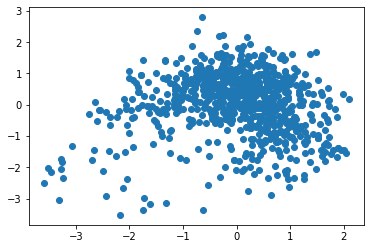

In [16]:
plt.scatter(pcXr.pc1, pcXr.pc2)

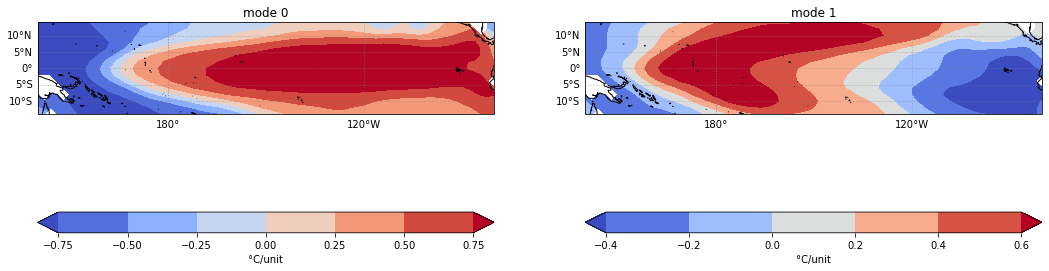

In [17]:
multiplyBy=[-1,1]

#Calc e and c
ecXr=xarray.Dataset()
ecXr['eIndex']=(multiplyBy[0]*pcXr.pc1-multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)
ecXr['cIndex']=(multiplyBy[0]*pcXr.pc1+multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)

#Average over warmseason and store
allWarmSeasXr=tp.averageForTimePeriod(ecXr)

#first plots of pc1 and pc2
fig=plt.figure(figsize=(18,12))
for mode in [0,1]:
    ax=fig.add_subplot(1,2,mode+1,
                   projection=ccrs.Miller(central_longitude=mapCentre))
    ec.ensoPlotter(
        multiplyBy[mode]*eofsXr.sel(mode=mode), ax)
    plt.title("mode " + str(mode))
plt.show()

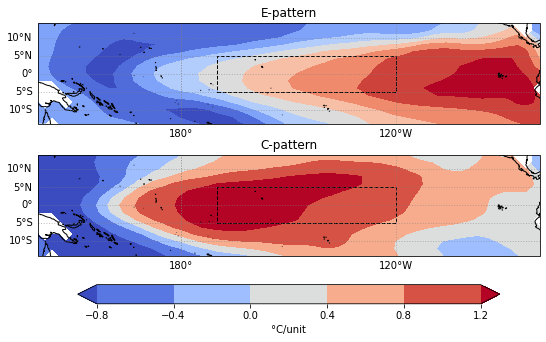

In [18]:
#then plots of e pattern and c pattern
fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(2,1,1,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(
    multiplyBy[0]*eofsXr.sel(mode=0)-multiplyBy[1]*eofsXr.sel(mode=1),
    ax, colorbar=False)
ax.add_patch(mpatches.Rectangle(
                xy=nino34Box['xy'], 
                width=nino34Box['width'], 
                height=nino34Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))

plt.draw()
plt.title("E-pattern")

ax=fig.add_subplot(2,1,2,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(multiplyBy[0]*eofsXr.sel(mode=0)+multiplyBy[1]*eofsXr.sel(mode=1), ax)
ax.add_patch(mpatches.Rectangle(
                xy=nino34Box['xy'], 
                width=nino34Box['width'], 
                height=nino34Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))
plt.title("C-pattern")
plt.subplots_adjust(hspace=-0.3)
plt.savefig('figures/obsEvsCPattern.pdf')
plt.show()


In [19]:
indexXr=xarray.merge([indexXr,allWarmSeasXr])

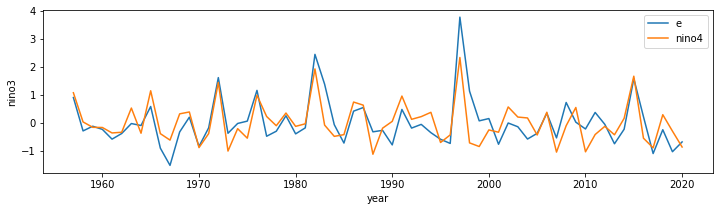

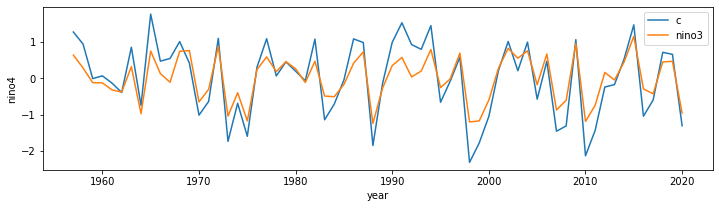

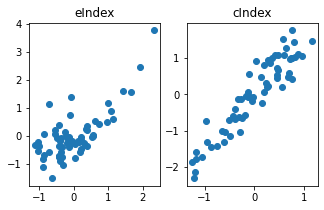

In [20]:
#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.eIndex.plot()
indexXr.nino3.plot()
plt.legend(['e','nino4'])


#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.cIndex.plot()
indexXr.nino4.plot()

#plt.xlim([1950,2050])
plt.legend(['c','nino3'])

#scatter plots
fig = plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.scatter(indexXr.nino3, indexXr.eIndex)
plt.title('eIndex')

plt.subplot(1,3,2)
plt.scatter(indexXr.nino4, indexXr.cIndex)
plt.title('cIndex')

plt.show()

# Marshall SAM

In [21]:
marshallPd=pandas.read_csv(
    'ref/marshallSam/newsam.1957.2007.txt',
    sep=' ', 
    skipinitialspace=True
)

In [22]:
marshallPd

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
1957,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78
2020,0.57,-0.36,2.05,-1.72,1.03,1.18,-0.97,-2.20,-0.25,1.79,1.14,2.28


In [23]:
marshallXr=marshallPd.to_xarray().to_array('month').rename({'index':'year'})

In [24]:
indexXr['samSummer']=xarray.DataArray(
    (
        marshallXr.sel(
            year=range(1957,2021),
            month=['OCT','NOV','DEC']
        ).sum('month').values  #This is the sep to dec sum for each year
        + marshallXr.sel(
            year=range(1958,2022),
            month=['JAN','FEB','MAR']
        ).sum('month').values   #This is the jan feb sum for the next year
    )/6, 
    {'year':marshallXr.year.values[0:-1]}, 
    dims='year'
)

In [25]:
indexXr['samWinter']=(
     marshallXr.sel(
        year=range(1957,2021),
        month=['APR','MAY','JUN','JUL','AUG','SEP']
    ).sum('month')
)/6

In [26]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables: (12/16)
    eastIONoDetrend         (year) float64 -0.2096 0.2706 ... -0.5503 0.4041
    nino34                  (year) float64 1.249 0.1411 ... 0.1489 -1.136
    nino34NoDetrend         (year) float64 1.183 0.1822 ... 0.4823 -0.8275
    westIO                  (year) float64 -0.0632 -0.0215 ... 0.2948 -0.2123
    backgroundSstNoDetrend  (year) float64 -0.01563 -0.1544 ... 0.5034 0.1919
    nino3                   (year) float64 1.068 0.02561 ... -0.3024 -0.8708
    ...                      ...
    nino4NoDetrend          (year) float64 0.4334 0.1294 ... 0.9657 -0.502
    dmiNoDetrend            (year) float64 -0.2578 -0.656 ... 1.441 0.01628
    cIndex                  (year) float64 1.267 0.9372 ... 0.6534 -1.307
    eIndex                  (year) float64 0.8971 -0.2954 ... -1.039 -0.6884
    samSummer               (year) float64 -2.748 0.3033 1.265 ... -0.985 1.4
    samWinter               (year) float64 -0.8917 -0.4617 ... -0.07833 -0.4883

In [28]:
#save them for use elsewhere

indexXr.to_netcdf('results/obsIndeces.nc')

# Now, set some criteria to determine events

Per normal, 1 sigma for enso/iod. 0.5 sigma for SAM.

However, we don't have a good baseline period. Lets choose 1900-1930 (somewhat arbitrary?)

In [29]:
indexXr=xarray.open_dataset('results/obsIndeces.nc')

In [30]:
stdXr=indexXr.std()

In [31]:
criteriaXr=stdXr[['dmi','nino34', 'eastIO', 'eIndex', 'cIndex']]
criteriaXr['samWinter']=stdXr.samWinter/2
criteriaXr['samSummer']=stdXr.samSummer/2

In [32]:
criteriaXr

<xarray.Dataset>
Dimensions:    ()
Data variables:
    dmi        float64 0.4629
    nino34     float64 0.8774
    eastIO     float64 0.3518
    eIndex     float64 0.8403
    cIndex     float64 1.011
    samWinter  float64 0.4147
    samSummer  float64 0.5544

In [33]:
firePosXr, fireNegXr = compound.applyCriteria(indexXr, criteriaXr)

firePos: 
['cIndex', 'eIndex', 'nino34', 'samWinter', 'dmi']
fireNeg: 
['eastIO', 'samSummer']


In [34]:
firePosXr

<xarray.Dataset>
Dimensions:    (year: 64)
Coordinates:
  * year       (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
Data variables:
    cIndex     (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    eIndex     (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    nino34     (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    samWinter  (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 0.0 0.0
    dmi        (year) float64 0.0 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    eastIO     (year) float64 0.0 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    samSummer  (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 1.0 0.0

In [35]:
eventsXr=xarray.concat(
    [
        firePosXr,
        fireNegXr
    ],
    'fire')

eventsXr['fire']=['pos','neg']

In [36]:
eventsXr['ecCombined']=eventsXr[['eIndex','cIndex']].to_array().any('variable')*1.0

In [37]:
eventsXr

<xarray.Dataset>
Dimensions:     (fire: 2, year: 64)
Coordinates:
  * year        (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
  * fire        (fire) <U3 'pos' 'neg'
Data variables:
    cIndex      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 0.0 1.0
    eIndex      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 1.0 0.0
    nino34      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    samWinter   (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    dmi         (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    eastIO      (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    samSummer   (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 1.0 0.0 1.0
    ecCombined  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 1.0 1.0

In [38]:
eventsXr.to_netcdf('results/obsEvents.nc')

In [39]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.where(
        eventsXr[iEvent].sel(fire='pos')==True, 
        drop=True
    ).year.values
    
    print(str(iEvent) + ' : ' + str(years))

cIndex : [1957 1965 1972 1977 1982 1986 1991 1994 2009 2015]
eIndex : [1957 1972 1976 1982 1983 1997 1998 2015]
nino34 : [1957 1965 1972 1982 1987 1991 1997 2002 2009 2015]
samWinter : [1967 1969 1976 1978 1979 1982 1985 1989 1993 1997 1998 1999 2001 2003
 2004 2005 2008 2010 2012 2015 2016 2017]
dmi : [1961 1963 1967 1972 1994 1997 2006 2012 2019]
eastIO : [1961 1963 1967 1985 1994 1997 2006 2019]
samSummer : [1957 1964 1966 1967 1968 1971 1974 1976 1979 1982 1984 1986 1991 2000
 2002 2016 2019]
ecCombined : [1957 1965 1972 1976 1977 1982 1983 1986 1991 1994 1997 1998 2009 2015]


Cai et al. 2015, (starting 1979, using ORA-s4 SST, DJF averages) identifies El Nino as:
- CP: 1990, 2002, 2004, 2009
- EP: 1982, 1997
They seem to match ok

Abram et al 2020 (observational):
- IOD: 1982, 1991, 1994, 1997, 2007, 2008, 2012, 2015, 2019 (bad)


In [40]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.where(
        eventsXr[iEvent].sel(fire='neg')==True, 
        drop=True
    ).year.values
    
    print(str(iEvent) + ' : ' + str(years))

cIndex : [1970 1973 1975 1983 1988 1998 1999 2000 2007 2008 2010 2011 2016 2020]
eIndex : [1966 1967 1970 2017 2019]
nino34 : [1970 1973 1975 1988 1998 1999 2007 2010 2020]
samWinter : [1957 1958 1963 1964 1968 1971 1972 1974 1975 1977 1980 1981 1988 1990
 1991 1992 1994 1996 2007 2009 2013 2020]
dmi : [1958 1960 1981 1992 1996 1998 2005 2010 2016]
eastIO : [1958 1960 1981 1989 1990 1992 1998 2005 2009 2016]
samSummer : [1959 1961 1962 1973 1981 1993 1996 1998 1999 2001 2006 2007 2008 2010
 2011 2012 2014 2015 2017 2018 2020]
ecCombined : [1966 1967 1970 1973 1975 1983 1988 1998 1999 2000 2007 2008 2010 2011
 2016 2017 2019 2020]


# Check events against the initial SSTs:

In [41]:
ensoSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='nino34'))
iodSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='dmi'))

In [42]:
%run helpers/impactPlots.ipynb

[<GeoAxesSubplot:title={'center':'eIndex'}>,
 <GeoAxesSubplot:title={'center':'cIndex'}>,
 <GeoAxesSubplot:title={'center':'nino34'}>]

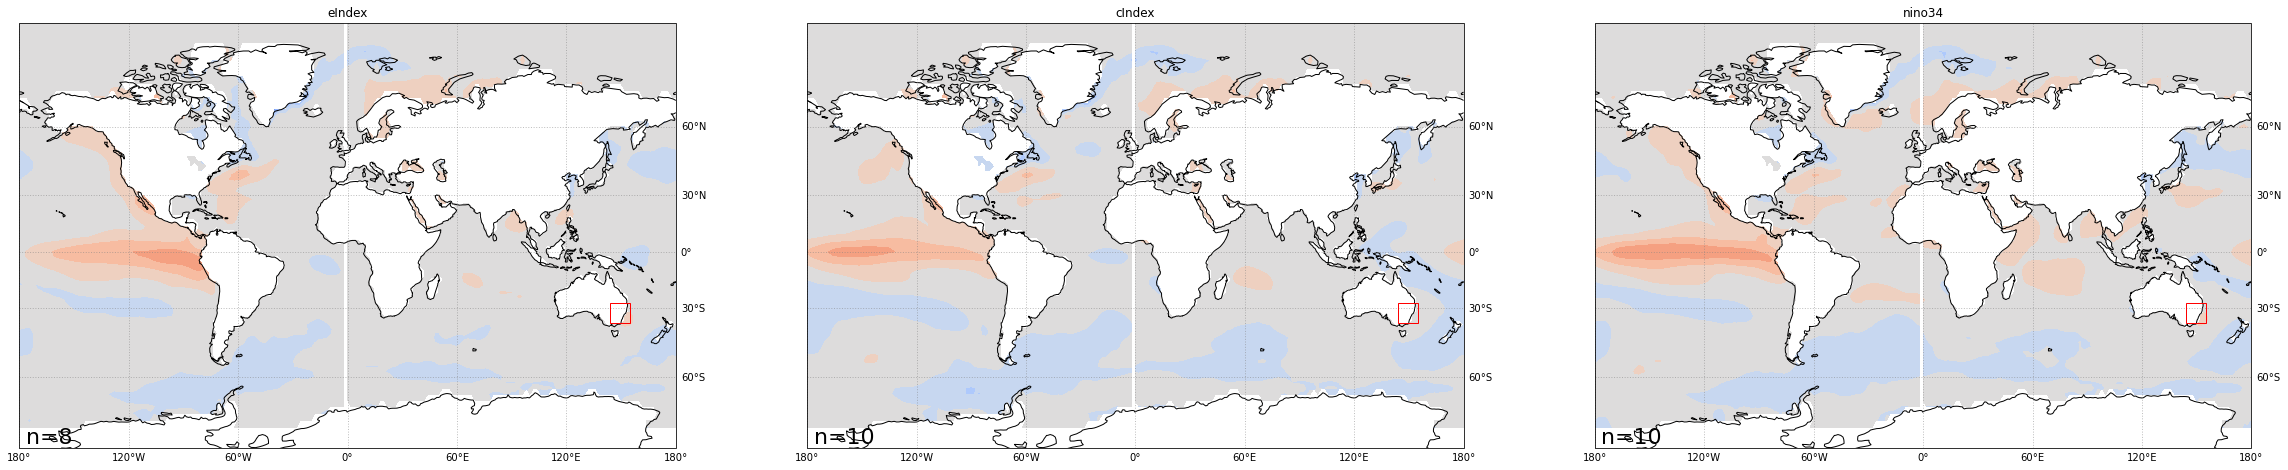

In [43]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['eIndex','cIndex','nino34'],
    showOcean=True, 
    stipling=False
)

[<GeoAxesSubplot:title={'center':'eIndex'}>,
 <GeoAxesSubplot:title={'center':'cIndex'}>,
 <GeoAxesSubplot:title={'center':'nino34'}>]

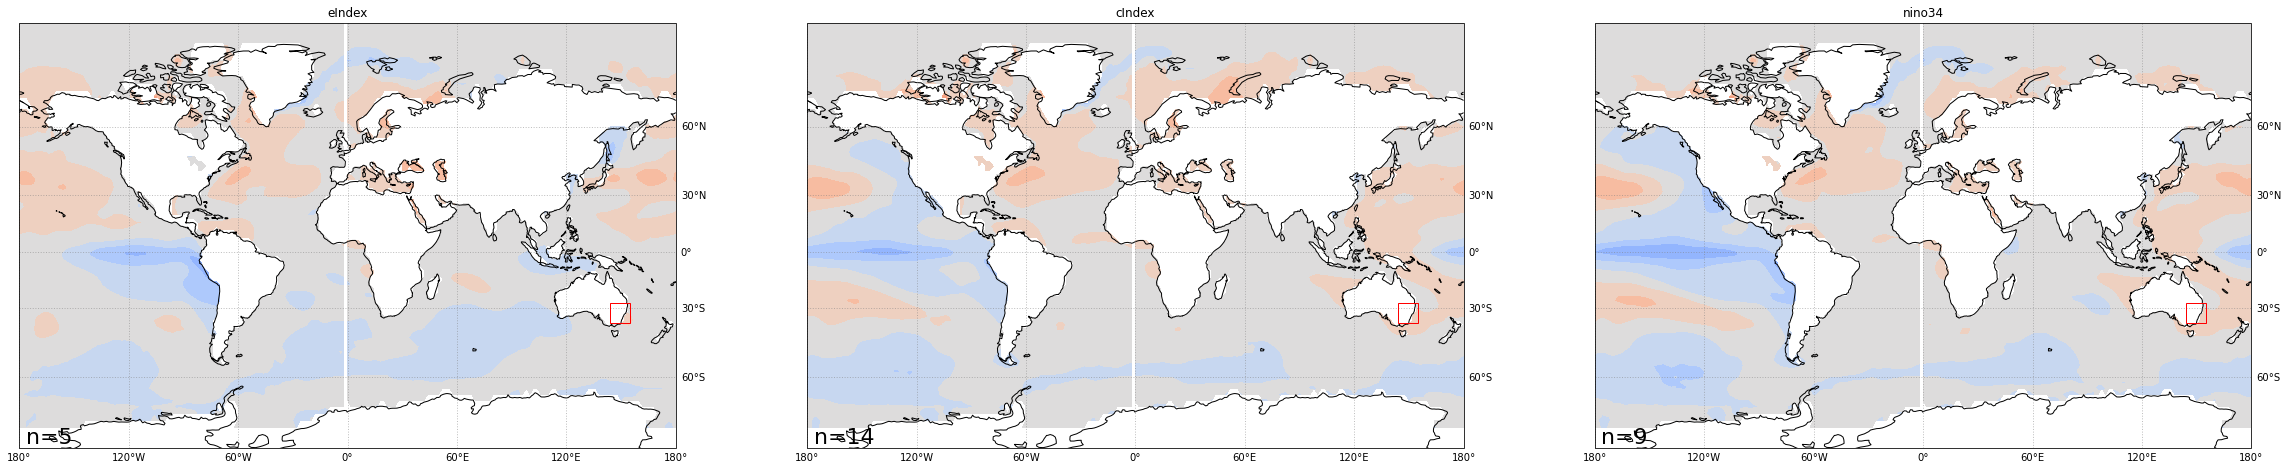

In [44]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['eIndex','cIndex','nino34'],
    showOcean=True, 
    stipling=False
)

[<GeoAxesSubplot:title={'center':'dmi'}>]

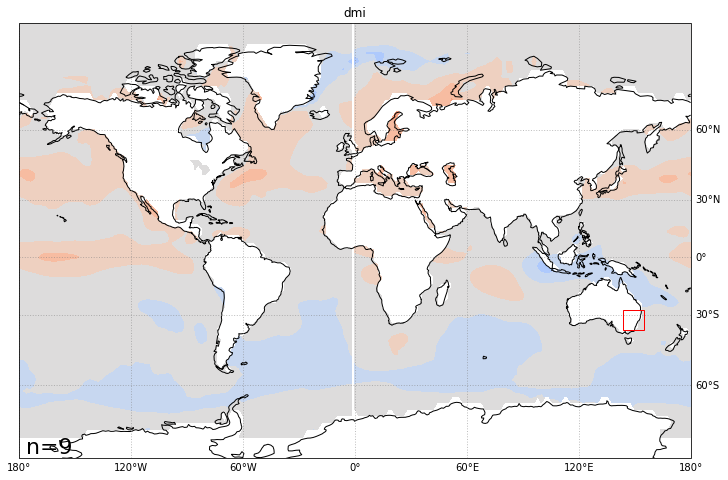

In [45]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['dmi'],
    showOcean=True, 
    stipling=False
)

[<GeoAxesSubplot:title={'center':'dmi'}>]

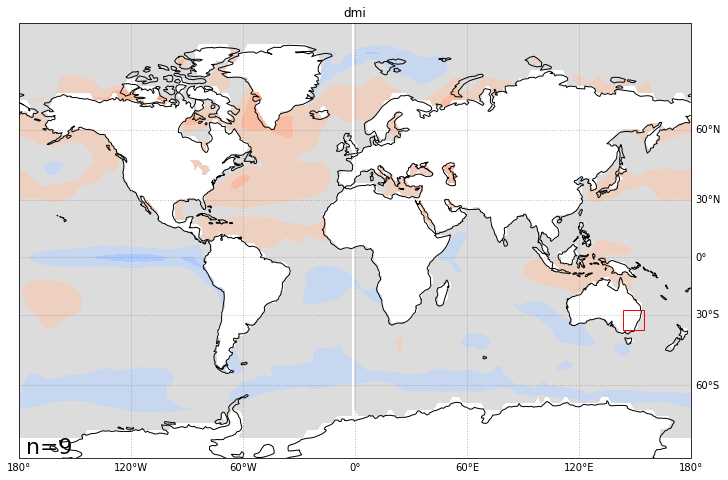

In [46]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['dmi'],
    showOcean=True, 
    stipling=False
)